In [ ]:
import os
from google.cloud import storage

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "..."

storage_client = storage.Client()

# Verify it works by listing buckets
for bucket in storage_client.list_buckets():
    print(bucket.name)

phil-ishan-dataset-bucket


In [ ]:
# Create mount point
!mkdir -p /content/gcs-bucket

# Mount your bucket (replace 'your-bucket-name' with your actual bucket name)
!gcsfuse --implicit-dirs phil-ishan-dataset-bucket /content/gcs-bucket

In [ ]:
# Looking at the file
!unzip -l /content/gcs-bucket/TexturedMeshQuality.zip

In [ ]:
# Get the readme
# !unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Subset of 3000 stimuli/readme.txt" -d /content/extracted_data

# Get collected MOS scores
# !unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Collected_Data/MOS+CI_3000stimuli.csv" -d /content/extracted_data

# !unzip -l /content/gcs-bucket/TexturedMeshQuality.zip

!unzip -l "/content/extracted_data/TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists1-20.zip"

In [ ]:
!unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists21-40.zip" -d /content/extracted_data

# Get collected MOS scores
# !unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Collected_Data/MOS+CI_3000stimuli.csv" -d /content/extracted_data

In [ ]:
!unzip -l "/content/extracted_data/TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists1-20.zip"

In [ ]:
!unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists21-40.zip" -d /content/extracted_data
!unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists41-60.zip" -d /content/extracted_data
!unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists61-80.zip" -d /content/extracted_data
!unzip /content/gcs-bucket/TexturedMeshQuality.zip "TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists81-100.zip" -d /content/extracted_data

In [ ]:
!unzip "/content/extracted_data/TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists1-20.zip" -d /content/extracted_data/extracted_playlists
!unzip "/content/extracted_data/TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists21-40.zip" -d /content/extracted_data/extracted_playlists
!unzip "/content/extracted_data/TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists41-60.zip" -d /content/extracted_data/extracted_playlists
!unzip "/content/extracted_data/TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists61-80.zip" -d /content/extracted_data/extracted_playlists
!unzip "/content/extracted_data/TexturedMeshQuality/Subset of 3000 stimuli/Playlists/Playlists81-100.zip" -d /content/extracted_data/extracted_playlists



In [ ]:
# Clone the GitHub repository
!git clone https://github.com/Lou1sM/meaningful_image_complexity


In [ ]:
# Install required packages
!pip install numpy scikit-learn scikit-image scipy pandas matplotlib opencv-python cmake
!pip install torch torchvision torchaudio imageio psutil Pillow tensorflow torch-summary tqdm


In [ ]:
# Import necessary libraries and modules
import sys
sys.path.append('/content/meaningful_image_complexity')  # Adjust the path to the cloned repository

import cv2
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from measure_complexity import ComplexityMeasurer


In [ ]:
def extract_frame(video_path, timestamp):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Error: Could not open video.")

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise ValueError(f"Error: Could not read frame at {timestamp:.2f} seconds.")

    return frame

def compute_clip_score(model, preprocess, frame, text_description, device):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_description]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (image_features @ text_features.T).item()

    return similarity

def compute_mdl_complexity_fast(frame):
    # Downsample the frame
    frame_small = cv2.resize(frame, (frame.shape[1] // 2, frame.shape[0] // 2))
    # Normalize the frame to [0, 1] and convert to float32
    normalized_frame = (frame_small / 255.0).astype(np.float32)
    # Initialize the complexity measurer with optimized parameters
    comp_meas = ComplexityMeasurer(
        ncs_to_check=2,
        n_cluster_inits=1,
        nz=3,
        num_levels=2,
        cluster_model='kmeans',
        info_subsample=0.1,
    )
    # Compute complexity at each level
    complexity_levels = comp_meas.interpret(normalized_frame)
    # Sum complexities across all levels
    total_complexity = sum(complexity_levels)
    return total_complexity

def compute_mdl_complexity_accurate(frame):
    # Slightly reduce downsampling to retain more detail
    frame_small = cv2.resize(frame, (int(frame.shape[1] * 0.75), int(frame.shape[0] * 0.75)))
    # Normalize the frame to [0, 1] and convert to float32
    normalized_frame = (frame_small / 255.0).astype(np.float32)
    # Initialize the complexity measurer with adjusted parameters
    comp_meas = ComplexityMeasurer(
      ncs_to_check=8,
      n_cluster_inits=1,
      nz=2,
      num_levels=4,
      cluster_model='GMM',
      info_subsample=0.3,
    )
    # Compute complexity at each level
    complexity_levels = comp_meas.interpret(normalized_frame)
    # Sum complexities across all levels
    total_complexity = sum(complexity_levels)
    return total_complexity


def process_video(video_path, timestamps, text_description):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    clip_scores = []
    mdl_complexities = []
    for t in timestamps:
        frame = extract_frame(video_path, t)
        score = compute_clip_score(model, preprocess, frame, text_description, device)
        complexity_value = compute_mdl_complexity_accurate(frame)
        clip_scores.append(score)
        mdl_complexities.append(complexity_value)
        print(f"Timestamp: {t:.2f} seconds, CLIP Score: {score:.4f}, MDL Complexity: {complexity_value:.4f}")

        # Display the frame
        # Convert the frame from BGR (OpenCV format) to RGB (matplotlib format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(frame_rgb)
        plt.title(f"Timestamp: {t:.2f}s\nCLIP Score: {score:.4f}, MDL Complexity: {complexity_value:.4f}")
        plt.axis('off')
        plt.show()

    return clip_scores, mdl_complexities

In [ ]:
"""
ON ONE FILE
"""

video_path = '/content/extracted_data/extracted_playlists/Playlist1/bronze-cat/bronzeCat_simpL1_qp10_qt9_decompJPEG_512x512_Q50.mp4'
timestamps = [1.5, 3.0, 4.5]  # List of timestamps in seconds
text_description = video_path.split('/')[-2]
clip_scores, mdl_complexities = process_video(video_path, timestamps, text_description)

print('CLIP Scores:', clip_scores)
print('mdl complexities:', mdl_complexities)

In [ ]:
"""
ALL FILES
"""

import os
from pathlib import Path

base_path = '/content/extracted_data/extracted_playlists'


number_of_videos = 0
already_seen = set()

# Loop through playlists 1-100
for playlist_num in range(1, 101):
    playlist_path = os.path.join(base_path, f"Playlist{playlist_num}")

    # Check if this playlist directory exists
    if not os.path.exists(playlist_path):
        continue

    # Loop through each label directory within the playlist
    for label_dir in os.listdir(playlist_path):
        label_path = os.path.join(playlist_path, label_dir)

        # Skip if not a directory
        if not os.path.isdir(label_path):
            continue

        # Loop through each MP4 in the label directory
        for file in os.listdir(label_path):
            if file.endswith('_Q10.mp4'):
                video_path = os.path.join(label_path, file)

                # Extract the label (directory name) using the method from before
                text_description = video_path.split('/')[-2]
                if text_description not in already_seen:
                  # Now you can work with:
                  # video_path - full path to the MP4
                  # file - name of the MP4 file
                  # text_description - the label (directory name)

                  print(f"Processing video number: {number_of_videos}")
                  print(f"Processing: {file}")
                  print(f"Label: {text_description}")
                  print(f"Full path: {video_path}")
                  print("---")

                  # clip_scores, mdl_complexities = process_video(video_path, timestamps, text_description)

                  # print('CLIP Scores:', clip_scores)
                  # print('mdl complexities:', mdl_complexities)

                  number_of_videos += 1
                  already_seen.add(text_description)

In [ ]:
import os
import pandas as pd

# Paths
base_path = '/content/extracted_data/extracted_playlists'
csv_path = '/content/extracted_data/TexturedMeshQuality/Collected_Data/MOS+CI_3000stimuli.csv'

# Read the existing CSV into a DataFrame
df = pd.read_csv(csv_path)

# Set 'stimulus' as index for easy lookup
df.set_index('stimulus', inplace=True)

# Add new columns if they don't exist
if 'Label' not in df.columns:
    df['Label'] = pd.NA  # Initialize with Not Available

if 'CLIP Scores' not in df.columns:
    df['CLIP Scores'] = pd.NA

if 'MDL Complexities' not in df.columns:
    df['MDL Complexities'] = pd.NA

# Initialize a set of already processed files
# We consider a file processed if 'CLIP Scores' is not NA
already_processed = set(df[df['CLIP Scores'].notna()].index)

number_of_videos = 0

already_seen = set()

# Loop through playlists 1-100
for playlist_num in range(1, 101):
    playlist_path = os.path.join(base_path, f"Playlist{playlist_num}")

    # Check if this playlist directory exists
    if not os.path.exists(playlist_path):
        continue

    # Loop through each label directory within the playlist
    for label_dir in os.listdir(playlist_path):
        label_path = os.path.join(playlist_path, label_dir)

        # Skip if not a directory
        if not os.path.isdir(label_path):
            continue

        # Loop through each MP4 in the label directory
        for file in os.listdir(label_path):
            if file.endswith('_Q10.mp4'):
                video_path = os.path.join(label_path, file)

                # Extract the label (directory name)
                text_description = video_path.split('/')[-2]

                if text_description in already_seen:
                    continue
                # Extract the file name without extension
                file_name_no_ext = os.path.splitext(file)[0]  # removes .mp4

                # Check if this stimulus has already been processed
                if file_name_no_ext in already_processed:
                    continue  # Skip already processed files

                # Process the video
                print(f"Processing video number: {number_of_videos}")
                print(f"Processing: {file}")
                print(f"Label: {text_description}")
                print(f"Full path: {video_path}")
                print("---")

                # Replace this with your actual processing function
                clip_scores, mdl_complexities = process_video(video_path, timestamps, text_description)
                # clip_scores = [1, 2, 3]
                # mdl_complexities = [3, 2, 1]

                print('CLIP Scores:', clip_scores)
                print('MDL Complexities:', mdl_complexities)

                # Update the DataFrame
                if file_name_no_ext in df.index:
                    # Update existing entry
                    df.at[file_name_no_ext, 'Label'] = text_description
                    df.at[file_name_no_ext, 'CLIP Scores'] = str(clip_scores)  # Convert list to string
                    df.at[file_name_no_ext, 'MDL Complexities'] = str(mdl_complexities)
                else:
                    # Add new entry if it doesn't exist
                    df.loc[file_name_no_ext] = {
                        'MOS': pd.NA,
                        'sd': pd.NA,
                        'freq': pd.NA,
                        'CI': pd.NA,
                        'Label': text_description,
                        'CLIP Scores': str(clip_scores),
                        'MDL Complexities': str(mdl_complexities)
                    }

                # Save the DataFrame back to CSV
                df.reset_index().to_csv(csv_path, index=False)

                number_of_videos += 1
                already_processed.add(file_name_no_ext)
                already_seen.add(text_description)


In [ ]:
# RESET
!cp /content/BACKUP_MOS+STIMULI.csv /content/extracted_data/TexturedMeshQuality/Collected_Data/MOS+CI_3000stimuli.csv

In [ ]:
# GET WEIGHTED CLIP LOSSES

import pandas as pd
import numpy as np

# Load the CSV files
file_path_slow = "/content/data_to_analyze/slow-run-results.csv"
data_slow = pd.read_csv(file_path_slow)

file_path_quick = "/content/data_to_analyze/quick-run-results.csv"
data_quick = pd.read_csv(file_path_quick)

# Function to compute the weighted average CLIP loss for a given p
def compute_weighted_clip_loss(row, p):
    # Extract complexities and clip scores
    complexities = np.array(eval(row["MDL Complexities"]))
    clip_scores = np.array(eval(row["CLIP Scores"]))

    # Step 1: Raise complexities to the power of p
    complexities_p = complexities ** p

    # Step 2: Normalize complexities to prevent overflow
    complexities_p -= np.max(complexities_p)  # Subtract max value for numerical stability

    # Step 3: Compute softmax of powered complexities
    exp_complexities = np.exp(complexities_p)
    softmax_weights = exp_complexities / np.sum(exp_complexities)

    # Step 4: Compute weighted average CLIP loss
    weighted_loss = np.dot(softmax_weights, clip_scores)
    return weighted_loss

# Values of p to iterate over
p_values = [-1, 0, 0.5, 1, 2, 4]

# Process datasets and save the results
datasets = {
    "slow_results_with_weighted_losses": data_slow,
    "quick_results_with_weighted_losses": data_quick
}

for output_name, dataset in datasets.items():
    for p in p_values:
        column_name = f"Weighted_CLIP_Loss_p{p}"
        dataset[column_name] = dataset.apply(lambda row: compute_weighted_clip_loss(row, p), axis=1)

    # Save the updated DataFrame to a new CSV file
    output_path = f"/content/data_to_analyze/{output_name}.csv"
    dataset.to_csv(output_path, index=False)

    # Display a message and optional preview
    print(f"Updated data saved to: {output_path}")
    print(dataset.head())

Updated data saved to: /content/data_to_analyze/slow_results_with_weighted_losses.csv
                                            stimulus       MOS        sd  \
0  170516_mia337_032122_600_200Kfaces_8192px_OBJ_...  3.846154  0.844127   
1  1970.16_Neck_Amphora_100K_simpL10_qp7_qt7_deco...  3.452381  0.861150   
2  abel_highpoly_meshexp_simpL10_qp7_qt6_decompJP...  2.853659  0.988963   
3  Ackerbau_BakedUV_simpL8_qp11_qt8_decompJPEG_10...  3.487805  0.778523   
4  Ailurodus_maculosus_simpL4_qp10_qt7_decompJPEG...  3.046512  0.843843   

   freq        CI                                Label  \
0    39  0.264930         12th-c-ce-water-moon-guanyin   
1    42  0.260442                  197016-neck-amphora   
2    41  0.302722                    abel-cable-mascot   
3    41  0.238306                         der-ackerbau   
4    43  0.252222  ailurodus-maculosus-spotted-catbird   

                                         CLIP Scores  \
0   [0.286376953125, 0.336181640625, 0.309326171875]

In [ ]:
# COMPUTING CORRELATIONS

import pandas as pd

# File paths for the datasets
file_paths = {
    "slow_results_with_weighted_losses": "/content/data_to_analyze/slow_results_with_weighted_losses.csv",
    "quick_results_with_weighted_losses": "/content/data_to_analyze/quick_results_with_weighted_losses.csv"
}

# Columns for correlation
mos_column = "MOS"
p_values = [-1, 0, 0.5, 1, 2, 4]
weighted_loss_columns = [f"Weighted_CLIP_Loss_p{p}" for p in p_values]

# Dictionary to store results for both datasets
all_correlation_results = {}

# Compute correlations for each dataset
for dataset_name, file_path in file_paths.items():
    # Load the dataset
    data = pd.read_csv(file_path)

    # Calculate correlations
    correlation_results = {}
    for col in weighted_loss_columns:
        if col in data.columns:
            correlation_results[col] = data[mos_column].corr(data[col])
        else:
            correlation_results[col] = None  # Handle missing columns gracefully

    # Store results
    all_correlation_results[dataset_name] = correlation_results

# Display results for each dataset
for dataset_name, correlations in all_correlation_results.items():
    print(f"\nCorrelation between MOS and Weighted CLIP Losses for {dataset_name}:")
    for col, corr in correlations.items():
        if corr is not None:
            print(f"{col}: {corr:.4f}")
        else:
            print(f"{col}: Not available")

# # Optionally save results to CSV
# output_path = "/content/data_to_analyze/correlation_results.csv"
# pd.DataFrame(all_correlation_results).transpose().to_csv(output_path)
# print(f"\nCorrelation results saved to: {output_path}")


Correlation between MOS and Weighted CLIP Losses for slow_results_with_weighted_losses:
Weighted_CLIP_Loss_p-1: 0.0557
Weighted_CLIP_Loss_p0: 0.0557
Weighted_CLIP_Loss_p0.5: 0.0558
Weighted_CLIP_Loss_p1: 0.0587
Weighted_CLIP_Loss_p2: 0.0768
Weighted_CLIP_Loss_p4: 0.0768

Correlation between MOS and Weighted CLIP Losses for quick_results_with_weighted_losses:
Weighted_CLIP_Loss_p-1: 0.0580
Weighted_CLIP_Loss_p0: 0.0557
Weighted_CLIP_Loss_p0.5: 0.0529
Weighted_CLIP_Loss_p1: 0.0481
Weighted_CLIP_Loss_p2: 0.0457
Weighted_CLIP_Loss_p4: 0.0459



Linear Regression Results for slow_results_with_weighted_losses:

Regression for Weighted_CLIP_Loss_p-1:
                            OLS Regression Results                            
Dep. Variable:                    MOS   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1619
Date:                Wed, 04 Dec 2024   Prob (F-statistic):              0.689
Time:                        17:05:41   Log-Likelihood:                -67.901
No. Observations:                  54   AIC:                             139.8
Df Residuals:                      52   BIC:                             143.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

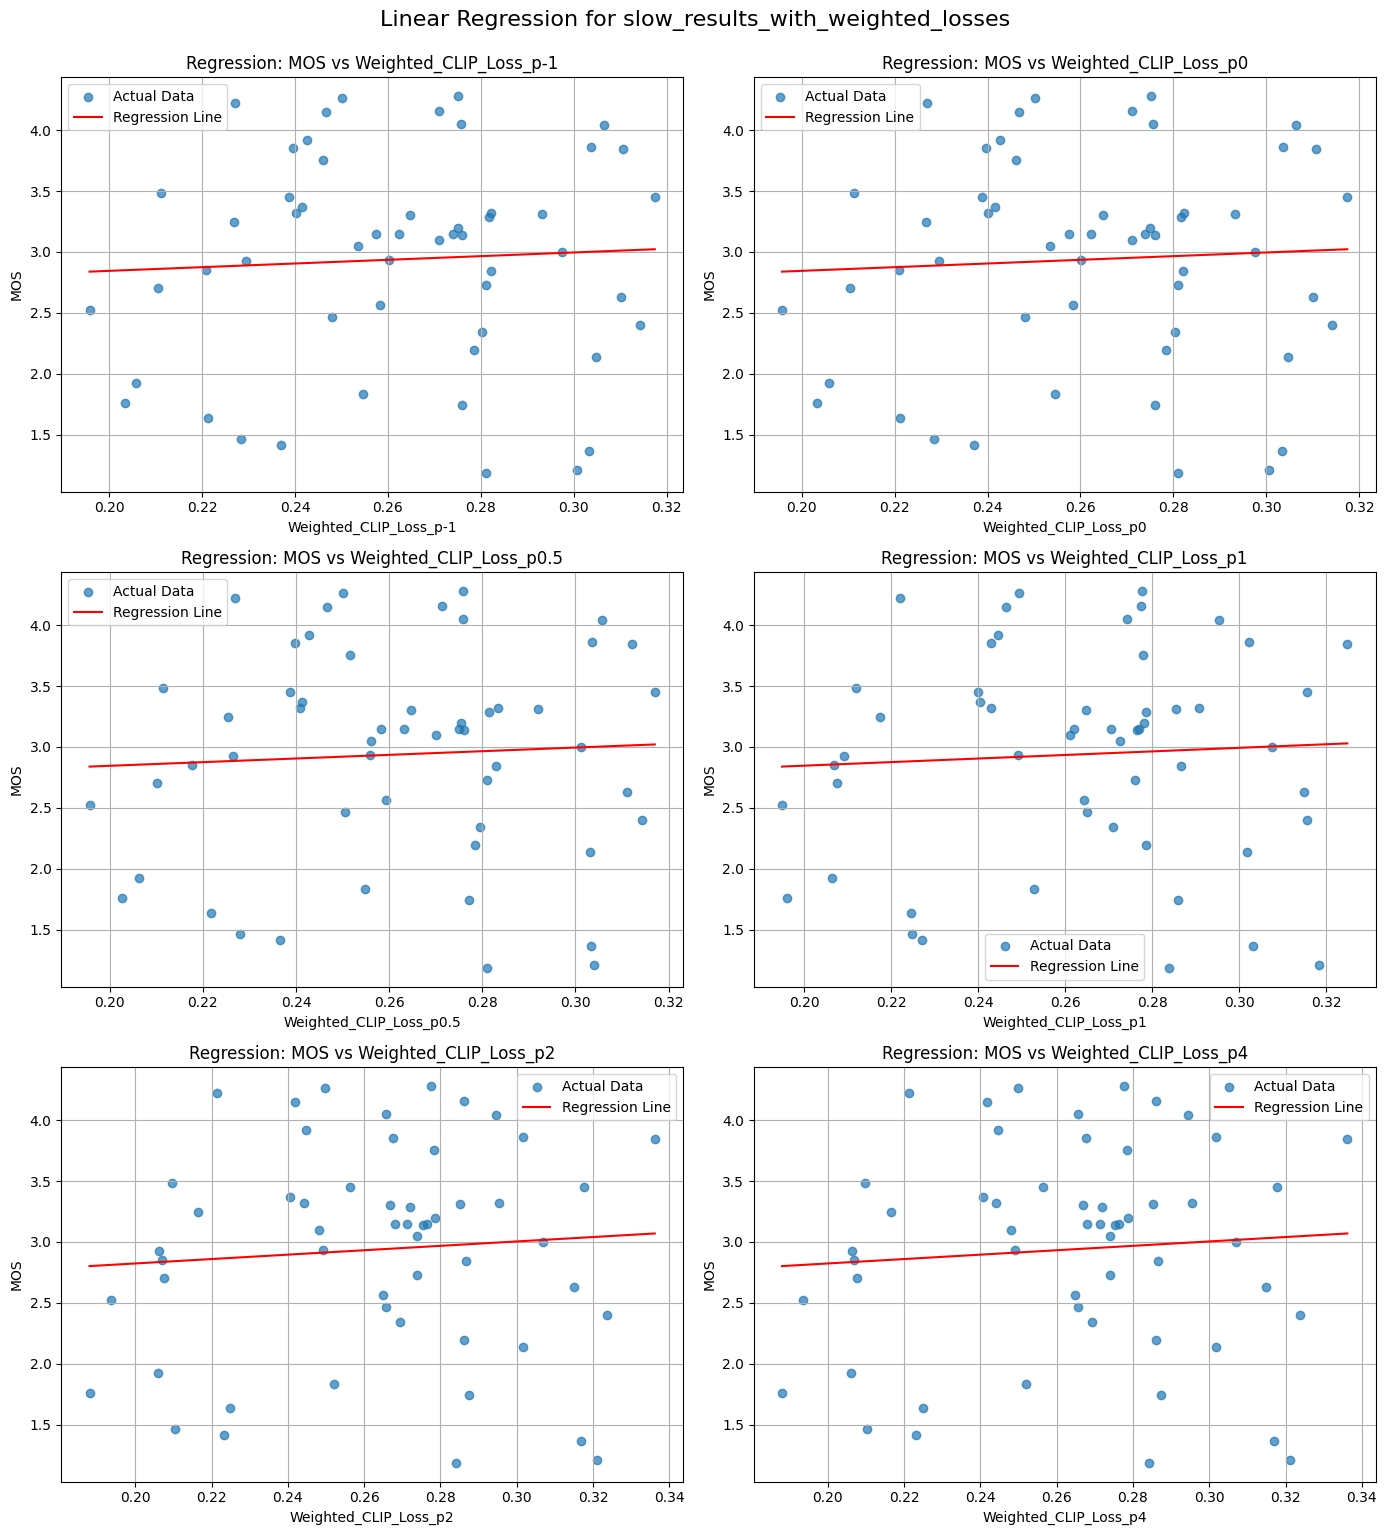


Linear Regression Results for quick_results_with_weighted_losses:

Regression for Weighted_CLIP_Loss_p-1:
                            OLS Regression Results                            
Dep. Variable:                    MOS   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1754
Date:                Wed, 04 Dec 2024   Prob (F-statistic):              0.677
Time:                        17:05:42   Log-Likelihood:                -67.894
No. Observations:                  54   AIC:                             139.8
Df Residuals:                      52   BIC:                             143.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------

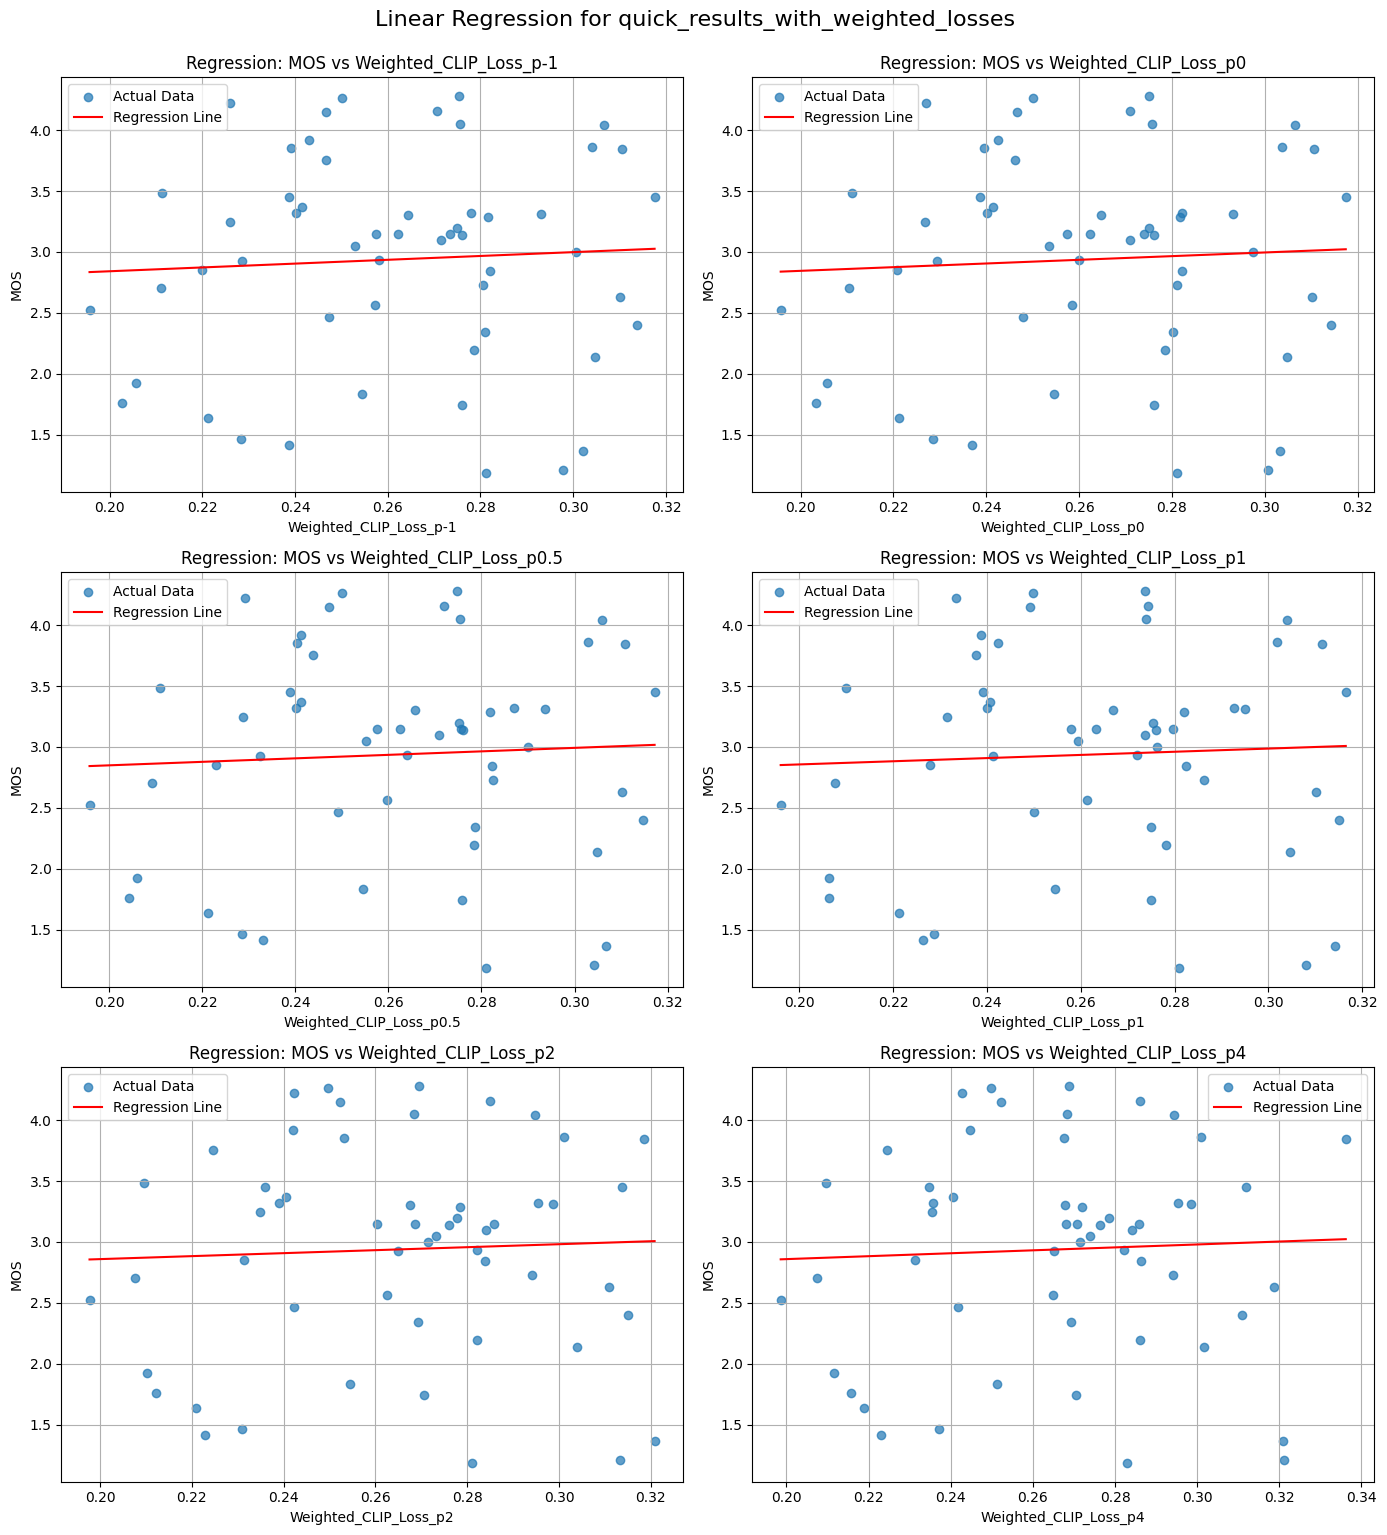

In [ ]:
# REGRESSIONS

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# File paths for the datasets
file_paths = {
    "slow_results_with_weighted_losses": "/content/data_to_analyze/slow_results_with_weighted_losses.csv",
    "quick_results_with_weighted_losses": "/content/data_to_analyze/quick_results_with_weighted_losses.csv"
}

# Columns for regression
mos_column = "MOS"
p_values = [-1, 0, 0.5, 1, 2, 4]
weighted_loss_columns = [f"Weighted_CLIP_Loss_p{p}" for p in p_values]

# Perform regressions and generate plots for each dataset
for dataset_name, file_path in file_paths.items():
    # Load the dataset
    data = pd.read_csv(file_path)

    # Set up the plot grid
    num_plots = len(weighted_loss_columns)
    rows = (num_plots + 1) // 2  # Determine rows for a 2-column layout
    fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 5))
    axes = axes.flatten()

    print(f"\nLinear Regression Results for {dataset_name}:")

    # Run regression and plot for each weighted loss column
    for i, col in enumerate(weighted_loss_columns):
        if col in data.columns:
            ax = axes[i]

            # Regression
            X = sm.add_constant(data[col])
            y = data[mos_column]
            model = sm.OLS(y, X).fit()

            # Display regression summary
            print(f"\nRegression for {col}:")
            print(model.summary())

            # Scatter plot of actual values
            ax.scatter(data[col], y, label="Actual Data", alpha=0.7)

            # Plot regression line
            x_vals = np.linspace(data[col].min(), data[col].max(), 100)
            y_vals = model.params["const"] + model.params[col] * x_vals
            ax.plot(x_vals, y_vals, color="red", label="Regression Line")

            # Labels and title
            ax.set_title(f"Regression: MOS vs {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("MOS")
            ax.legend()
            ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(f"Linear Regression for {dataset_name}", fontsize=16, y=1.02)
    plt.show()


Cubic Regression Results for slow_results_with_weighted_losses:
Weighted_CLIP_Loss_p-1: y = 4154.104x^3 + -3389.038x^2 + 912.368x + -78.033, R² = 0.0744
Weighted_CLIP_Loss_p0: y = 4152.908x^3 + -3388.158x^2 + 912.155x + -78.016, R² = 0.0744
Weighted_CLIP_Loss_p0.5: y = 3924.529x^3 + -3217.183x^2 + 869.921x + -74.569, R² = 0.0741
Weighted_CLIP_Loss_p1: y = 2288.777x^3 + -1963.736x^2 + 552.163x + -47.881, R² = 0.0796
Weighted_CLIP_Loss_p2: y = 2283.547x^3 + -1969.454x^2 + 555.734x + -48.293, R² = 0.1135
Weighted_CLIP_Loss_p4: y = 2284.596x^3 + -1970.356x^2 + 555.987x + -48.316, R² = 0.1136


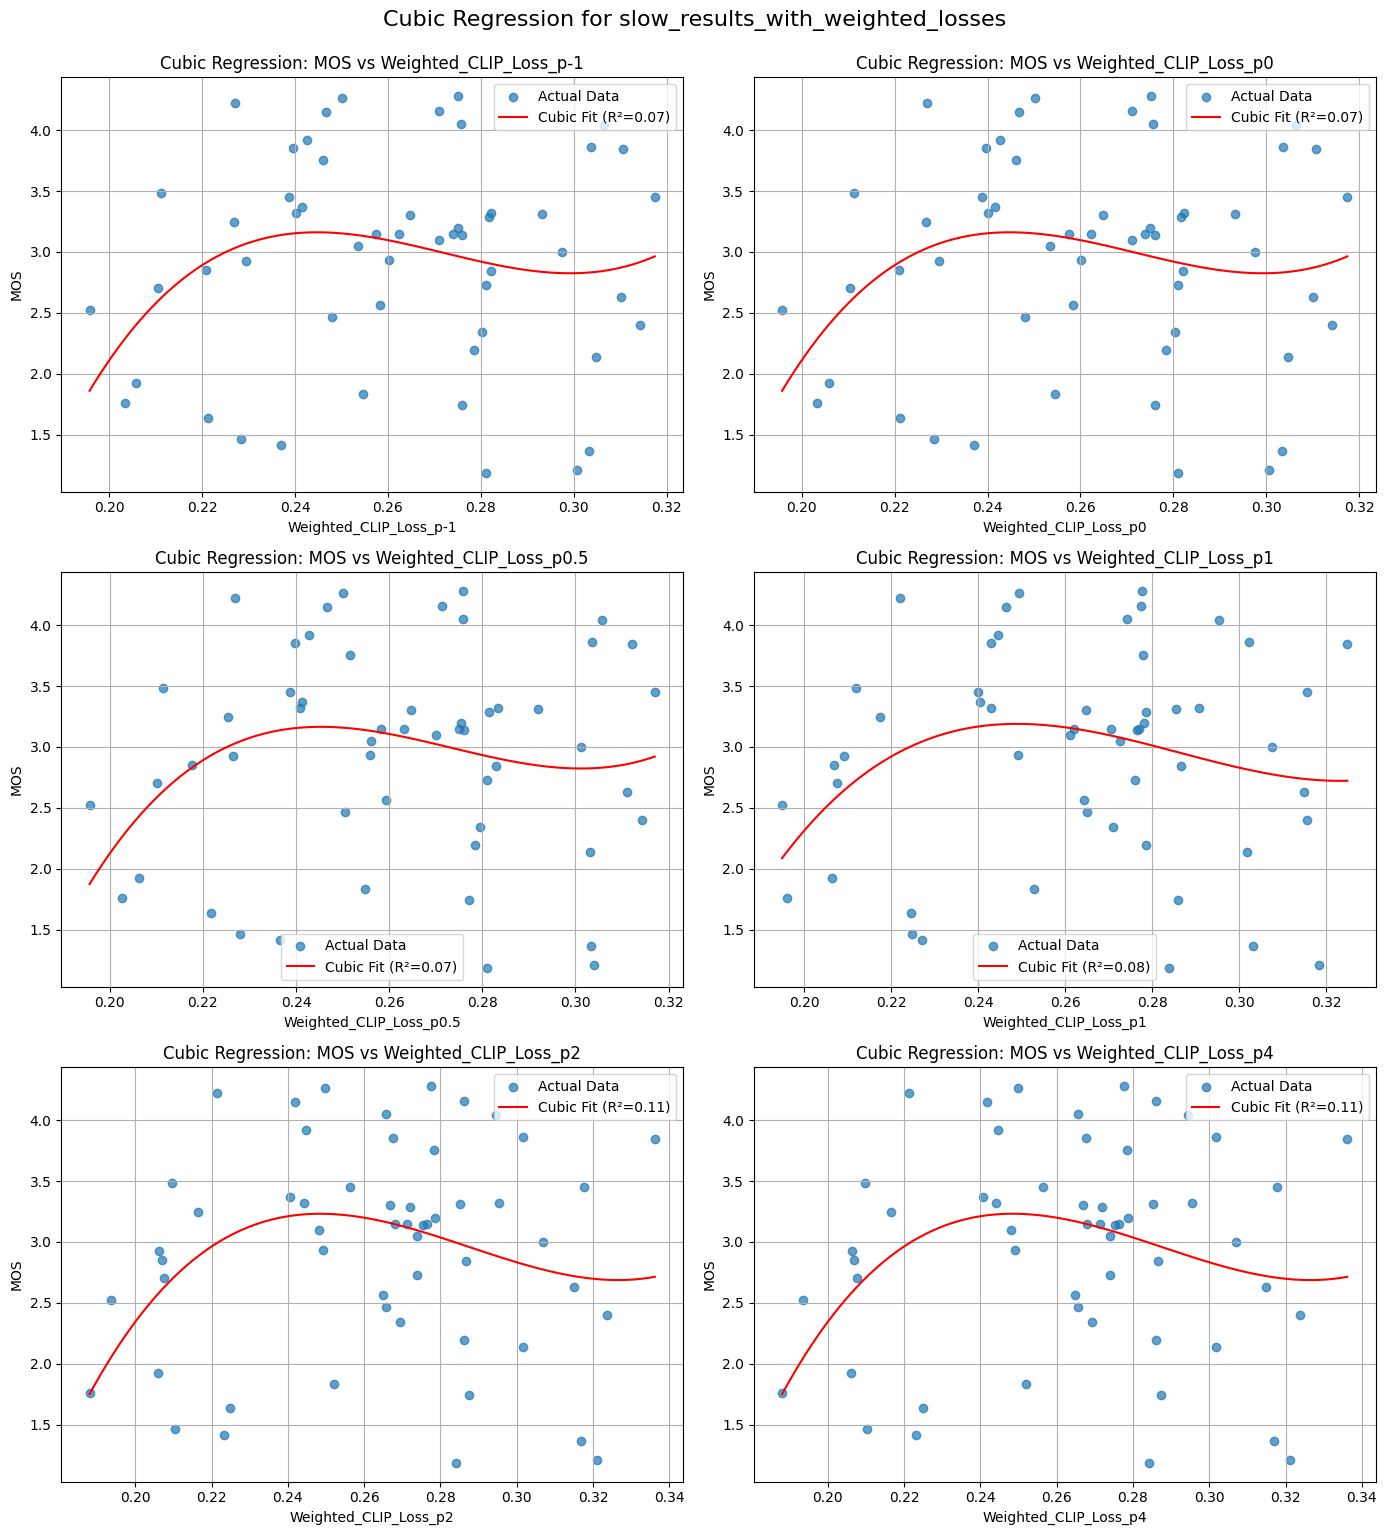


Cubic Regression Results for quick_results_with_weighted_losses:
Weighted_CLIP_Loss_p-1: y = 4647.973x^3 + -3758.561x^2 + 1003.336x + -85.399, R² = 0.0754
Weighted_CLIP_Loss_p0: y = 4152.908x^3 + -3388.158x^2 + 912.155x + -78.016, R² = 0.0744
Weighted_CLIP_Loss_p0.5: y = 3219.696x^3 + -2688.859x^2 + 739.734x + -64.032, R² = 0.0757
Weighted_CLIP_Loss_p1: y = 1537.761x^3 + -1417.832x^2 + 423.552x + -38.150, R² = 0.0847
Weighted_CLIP_Loss_p2: y = -282.623x^3 + -17.568x^2 + 69.177x + -8.658, R² = 0.0959
Weighted_CLIP_Loss_p4: y = 1876.039x^3 + -1684.614x^2 + 493.969x + -44.367, R² = 0.0791


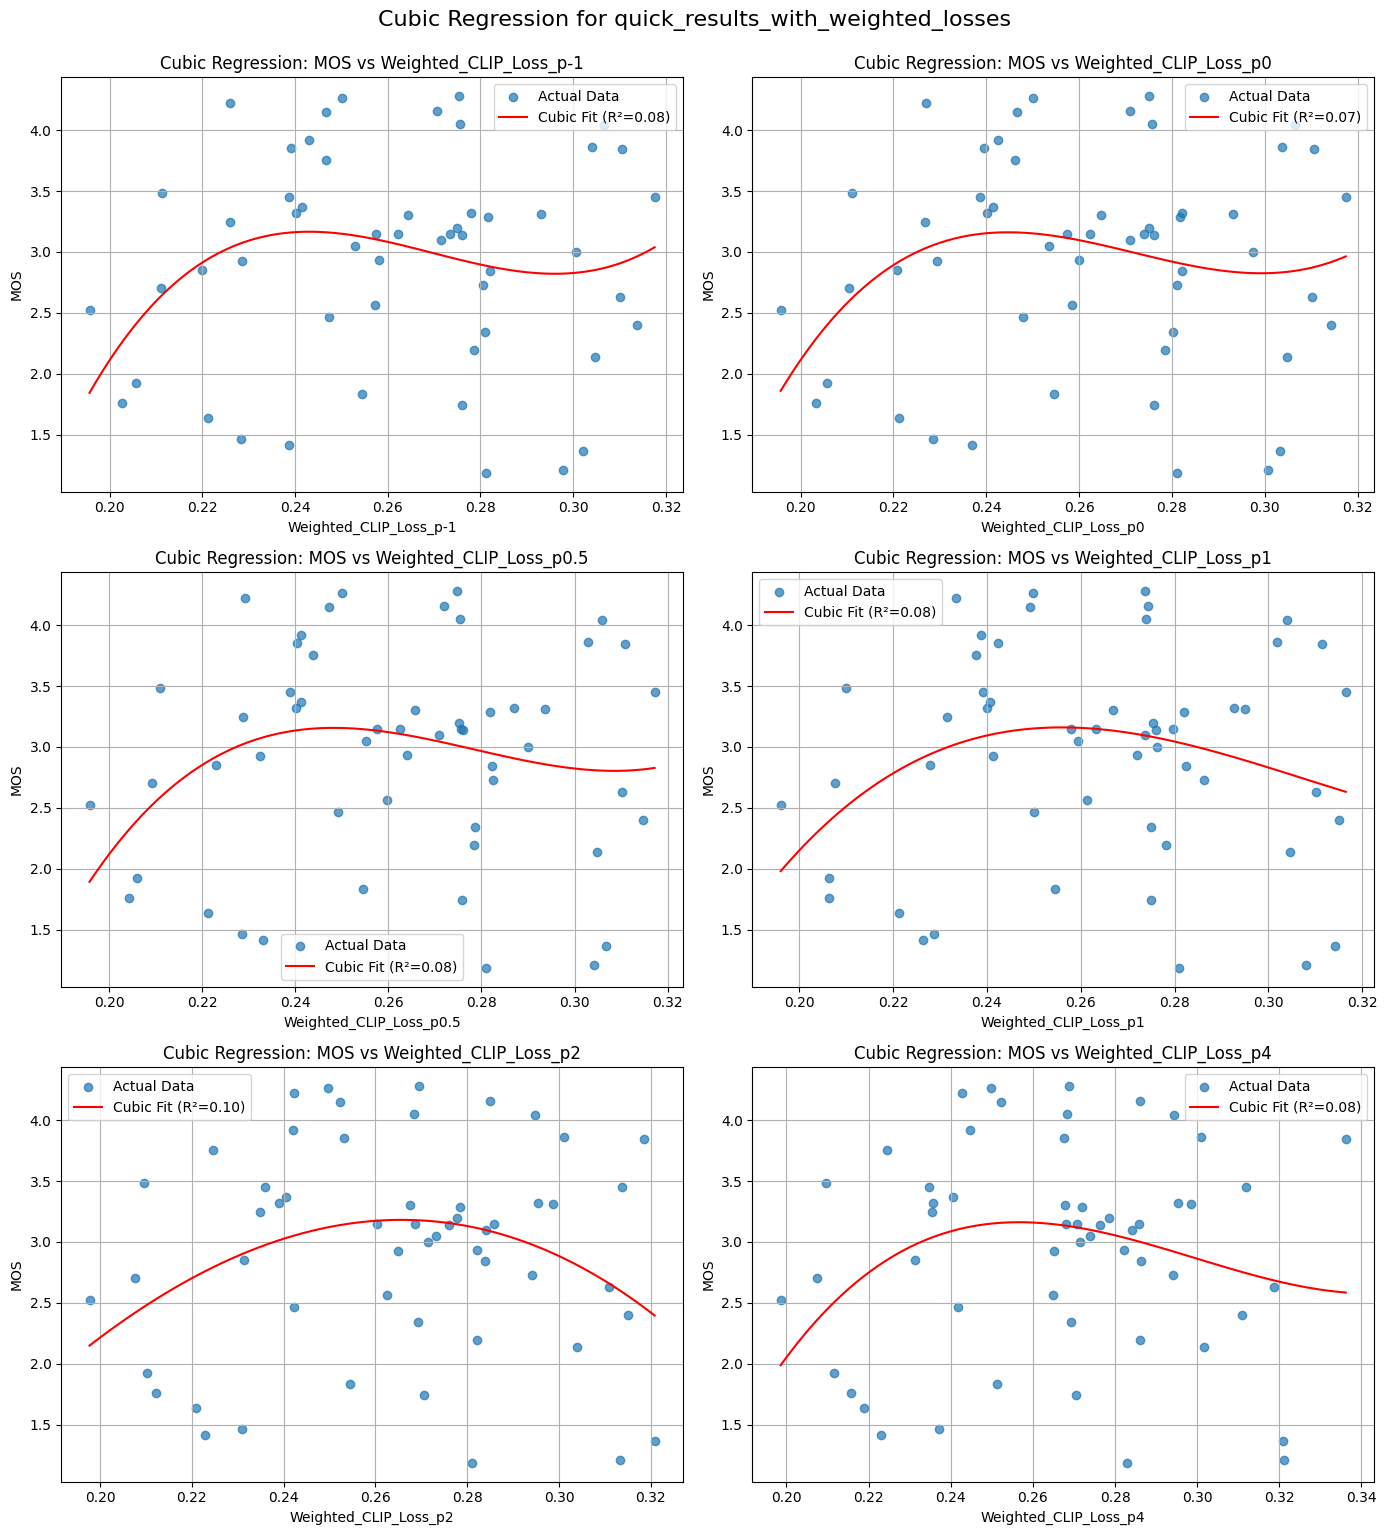

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths for the datasets
file_paths = {
    "slow_results_with_weighted_losses": "/content/data_to_analyze/slow_results_with_weighted_losses.csv",
    "quick_results_with_weighted_losses": "/content/data_to_analyze/quick_results_with_weighted_losses.csv"
}

# Columns for regression
mos_column = "MOS"
p_values = [-1, 0, 0.5, 1, 2, 4]
weighted_loss_columns = [f"Weighted_CLIP_Loss_p{p}" for p in p_values]

# Perform cubic regression for each dataset
for dataset_name, file_path in file_paths.items():
    # Load the dataset
    data = pd.read_csv(file_path)

    # Set up the plot grid
    num_plots = len(weighted_loss_columns)
    rows = (num_plots + 1) // 2  # Determine rows for a 2-column layout
    fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 5))
    axes = axes.flatten()

    print(f"\nCubic Regression Results for {dataset_name}:")

    # Run cubic regression and plot for each weighted loss column
    for i, col in enumerate(weighted_loss_columns):
        if col in data.columns:
            ax = axes[i]

            # Extract data
            X = data[col].dropna().values
            y = data[mos_column].dropna().values

            # Fit a cubic model
            coeffs = np.polyfit(X, y, 3)
            cubic_poly = np.poly1d(coeffs)

            # Generate predictions
            y_pred = cubic_poly(X)

            # Compute R² value
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)

            # Print cubic equation and R² value
            print(f"{col}: y = {coeffs[0]:.3f}x^3 + {coeffs[1]:.3f}x^2 + {coeffs[2]:.3f}x + {coeffs[3]:.3f}, R² = {r_squared:.4f}")

            # Scatter plot of actual values
            ax.scatter(X, y, label="Actual Data", alpha=0.7)

            # Plot regression curve
            x_vals = np.linspace(X.min(), X.max(), 100)
            y_vals = cubic_poly(x_vals)
            ax.plot(x_vals, y_vals, color="red", label=f"Cubic Fit (R²={r_squared:.2f})")

            # Labels and title
            ax.set_title(f"Cubic Regression: MOS vs {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("MOS")
            ax.legend()
            ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(f"Cubic Regression for {dataset_name}", fontsize=16, y=1.02)
    plt.show()
